---
syncID: 61ad1fc43ddd45b49cad1bca48656bbe
title: "NEON AOP Hyperspectral Data in HDF5 format with Python" 
description: "Learn how to read NEON AOP L3 reflectance h5 data in Python and visualize spectral data."
dateCreated: 2018-07-04 
authors: Bridget Hass
contributors: Donal O'Leary
estimatedTime: 1 hour
packagesLibraries: numpy, h5py, gdal, matplotlib, scikit-image, ipywidgets
topics: hyperspectral-remote-sensing, HDF5, remote-sensing, reflectance
languagesTool: python
dataProduct: DP3.30006.001,
code1: https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/Hyperspectral/intro-hyperspectral/intro-refl-h5/intro-l3-refl-h5.ipynb
tutorialSeries: intro-hsi-py-series
urlTitle: neon-refl-h5-py
---


In this introductory tutorial, we demonstrate how to read NEON AOP hyperspectral reflectance (Level 3, tiled) data in Python. This starts with the fundamental steps of reading in and exploring the HDF5 (h5) format that the reflectance data is delivered in. Then you will develop and practice skills to explore and visualize the spectral data. 

<div id="ds-objectives" markdown="1">
    
### Learning Objectives

After completing this tutorial, you will be able to:

* Use the package `h5py` and the `visititems` method to read a reflectance HDF5 file and view data attributes.
* Read the data ignore value and scaling factor and apply these values to produce a "cleaned" reflectance array.
* Plot a histogram of reflectance values to visualize the range and distribution of values.
* Extract and plot a single band of reflectance data.
* Apply a histogram stretch and adaptive equalization to improve the contrast of an image. 


### Install Python Packages

* **numpy**
* **pandas**
* **gdal** 
* **matplotlib** 
* **h5py**


### Download Data

To complete this tutorial, you will download and read in surface directional reflectance data collected at the NEON <a href="https://www.neonscience.org/field-sites/serc" target="_blank">Smithsonian Environmental Research Center (SERC)</a> site in Maryland. This data is downloaded in the first part of the tutorial, using a function that will download data from the NEON data portal using the Python requests package.

### Additional Resources
More details about the surface directional reflectance data product can be found on the data product page, linked below.
- <a href="https://data.neonscience.org/data-products/DP3.30006.001" target="_blank">Spectrometer orthorectified surface directional reflectance - mosaic</a>

In addition, 
NEON'S Airborne Observation Platform provides Algorithm Theoretical Basis Documents (ATBDs) for all of their data products. Please refer to the ATBDs below for a more in-depth understanding ofthe reflectance datad.
- <a href="https://data.neonscience.org/api/v0/documents/NEON.DOC.001288vB?inline=true" target="_blank">NEON Imaging Spectrometer Radiance to Reflectance ATBD</a>
- <a href="https://data.neonscience.org/api/v0/documents/NEON.DOC.004365vB?inline=true" target="_blank">Spectrometer Mosaic ATBD</a>

</div>


Hyperspectral remote sensing data is a useful tool for measuring changes to our 
environment at the Earth’s surface. In this tutorial we explore how to extract 
information from a tile (1000m x 1000m x 426 bands) of NEON AOP orthorectified surface reflectance data, stored in hdf5 format. For more information on this data product, refer to the <a href="http://data.neonscience.org/data-products/DP3.30006.001" target="_blank">NEON Data Product Catalog</a>.

#### Mapping the Invisible: Introduction to Spectral Remote Sensing

For more information on spectral remote sensing watch this video. 

<iframe width="560" height="315" src="https://www.youtube.com/embed/3iaFzafWJQE" frameborder="0" allowfullscreen></iframe>


## Set up


First let's import the required packages:

In [2]:
import os
import requests
import numpy as np
import h5py
from osgeo import gdal
import matplotlib.pyplot as plt

/Users/kitlewers/NEON_Ambassador_Training/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Read in the datasets
To start, we will download the NEON surface reflectance data (DP3.30006.001) which are provided in hdf5 (.h5) format. Use the `download_url` function below to download the data directly from the cloud storage location.

In [3]:
# function to download data stored on the internet in a public url to a local file
def download_url(url,download_dir):
    if not os.path.isdir(download_dir):
        os.makedirs(download_dir)
    filename = url.split('/')[-1]
    r = requests.get(url, allow_redirects=True)
    file_object = open(os.path.join(download_dir,filename),'wb')
    file_object.write(r.content)

In [4]:
# display the contents in the ./data folder to confirm the download completed
os.listdir('/Users/kitlewers/NEON_Ambassador_Training/January_Tutorial/data')

['NEON_D02_SERC_DP3_368000_4306000_reflectance.h5']

## Read in hdf5 file

```f = h5py.File('file.h5','r')``` reads in an h5 file to the variable f. 

### Using the help
We will be using a number of built-in and user-defined functions and methods throughout the tutorial. If you are uncertain what a certain function does, or how to call it, you can type `help()` or type a 
`?` at the end of the function or method and run the cell (either select Cell > Run Cells or Shift Enter with your cursor in the cell you want to run). The `?` will pop up a window at the bottom of the notebook displaying the function's `docstrings`, which includes information about the function and usage. We encourage you to use `help` and `?` throughout the tutorial as you come across functions you are unfamiliar with. Try out these commands:

`help(h5py)`

or 

`h5py.File?`

Now that we have an idea of how to use `h5py` to read in an h5 file, let's use this to explore the hyperspectral reflectance data. Note that if the h5 file is stored in a different directory than where you are running your notebook, you need to include the path (either relative or absolute) to the directory where that data file is stored. Use `os.path.join` to create the full path of the file. 

In [5]:
# Note that you may need to update this filepath for your local machine
f = h5py.File('/Users/kitlewers/NEON_Ambassador_Training/January_Tutorial/data/NEON_D02_SERC_DP3_368000_4306000_reflectance.h5','r')

## Explore NEON AOP HDF5 Reflectance Files

We can look inside the HDF5 dataset with the ```h5py visititems``` function. The ```list_dataset``` function defined below displays all datasets stored in the hdf5 file and their locations within the hdf5 file:

In [6]:
#list_dataset lists the names of datasets in an hdf5 file
def list_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(name)

f.visititems(list_dataset)

SERC/Reflectance/Metadata/Ancillary_Imagery/Aerosol_Optical_Depth
SERC/Reflectance/Metadata/Ancillary_Imagery/Aspect
SERC/Reflectance/Metadata/Ancillary_Imagery/Cast_Shadow
SERC/Reflectance/Metadata/Ancillary_Imagery/Dark_Dense_Vegetation_Classification
SERC/Reflectance/Metadata/Ancillary_Imagery/Data_Selection_Index
SERC/Reflectance/Metadata/Ancillary_Imagery/Haze_Cloud_Water_Map
SERC/Reflectance/Metadata/Ancillary_Imagery/Illumination_Factor
SERC/Reflectance/Metadata/Ancillary_Imagery/Path_Length
SERC/Reflectance/Metadata/Ancillary_Imagery/Sky_View_Factor
SERC/Reflectance/Metadata/Ancillary_Imagery/Slope
SERC/Reflectance/Metadata/Ancillary_Imagery/Smooth_Surface_Elevation
SERC/Reflectance/Metadata/Ancillary_Imagery/Visibility_Index_Map
SERC/Reflectance/Metadata/Ancillary_Imagery/Water_Vapor_Column
SERC/Reflectance/Metadata/Ancillary_Imagery/Weather_Quality_Indicator
SERC/Reflectance/Metadata/Coordinate_System/Coordinate_System_String
SERC/Reflectance/Metadata/Coordinate_System/EPSG C

You can see that there is a lot of information stored inside this reflectance hdf5 file. Most of this information is *metadata* (data about the reflectance data), for example, this file stores input parameters used in the atmospheric correction. For this introductory lesson, we will only work with two of these datasets, the reflectance data (hyperspectral cube), and the corresponding geospatial information, stored in Metadata/Coordinate_System:

- `SERC/Reflectance/Reflectance_Data`
- `SERC/Reflectance/Metadata/Coordinate_System/`

We can also display the name, shape, and type of each of these datasets using the `ls_dataset` function defined below, which is also called with the `visititems` method: 

In [7]:
#ls_dataset displays the name, shape, and type of datasets in hdf5 file
def ls_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(node)

Data Tip: To see what the visititems method (or any method) does, type ? at the end, eg.
`f.visititems?`

In [8]:
f.visititems(ls_dataset)

<HDF5 dataset "Aerosol_Optical_Depth": shape (1000, 1000), type "<i2">
<HDF5 dataset "Aspect": shape (1000, 1000), type "<f4">
<HDF5 dataset "Cast_Shadow": shape (1000, 1000), type "|u1">
<HDF5 dataset "Dark_Dense_Vegetation_Classification": shape (1000, 1000), type "|u1">
<HDF5 dataset "Data_Selection_Index": shape (1000, 1000), type "<i4">
<HDF5 dataset "Haze_Cloud_Water_Map": shape (1000, 1000), type "|u1">
<HDF5 dataset "Illumination_Factor": shape (1000, 1000), type "|u1">
<HDF5 dataset "Path_Length": shape (1000, 1000), type "<f4">
<HDF5 dataset "Sky_View_Factor": shape (1000, 1000), type "|u1">
<HDF5 dataset "Slope": shape (1000, 1000), type "<f4">
<HDF5 dataset "Smooth_Surface_Elevation": shape (1000, 1000), type "<f4">
<HDF5 dataset "Visibility_Index_Map": shape (1000, 1000), type "|u1">
<HDF5 dataset "Water_Vapor_Column": shape (1000, 1000), type "<f4">
<HDF5 dataset "Weather_Quality_Indicator": shape (1000, 1000, 3), type "|u1">
<HDF5 dataset "Coordinate_System_String": shap

Now that we can see the structure of the hdf5 file, let's take a look at some of the information that is stored inside. Let's start by extracting the reflectance data, which is nested under `SERC/Reflectance/Reflectance_Data`:  

In [9]:
serc_refl = f['SERC']['Reflectance']
print(serc_refl)

<HDF5 group "/SERC/Reflectance" (2 members)>


The two members of the HDF5 group `/SERC/Reflectance` are `Metadata` and `Reflectance_Data`. Let's save the reflectance data as the variable serc_reflArray:

In [10]:
serc_reflArray = serc_refl['Reflectance_Data']
print(serc_reflArray)

<HDF5 dataset "Reflectance_Data": shape (1000, 1000, 426), type "<i2">


We can extract the size of this reflectance array that we extracted using the `shape` method:

In [11]:
refl_shape = serc_reflArray.shape
print('SERC Reflectance Data Dimensions:',refl_shape)

SERC Reflectance Data Dimensions: (1000, 1000, 426)


This 3-D shape (1000,1000,426) corresponds to (y,x,bands), where (x,y) are the dimensions of the reflectance array in pixels. Hyperspectral data sets are often called "cubes" to reflect this 3-dimensional shape.

<figure>
    <a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/DataCube.png">
    <img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/DataCube.png"></a>
    <figcaption> A "cube" showing a hyperspectral data set. Source: National Ecological Observatory Network
    (NEON)  
    </figcaption>
</figure>


NEON hyperspectral data contain around 426 spectral bands, and when working with tiled data, the spatial dimensions are 1000 x 1000, where each pixel represents 1 meter. Now let's take a look at the wavelength values. First, we will extract wavelength information from the `serc_refl` variable that we created:

In [12]:
#define the wavelengths variable
wavelengths = serc_refl['Metadata']['Spectral_Data']['Wavelength']

#View wavelength information and values
print('wavelengths:',wavelengths)

wavelengths: <HDF5 dataset "Wavelength": shape (426,), type "<f4">


We can then use `numpy` (imported as `np`) to see the minimum and maximum wavelength values:

In [13]:
# Display min & max wavelengths
print('min wavelength:', np.amin(wavelengths),'nm')
print('max wavelength:', np.amax(wavelengths),'nm')

min wavelength: 383.884 nm
max wavelength: 2512.1804 nm


Finally, we can determine the band widths (distance between center bands of two adjacent bands). Let's try this for the first two bands and the last two bands. Remember that Python uses 0-based indexing (`[0]` represents the first value in an array), and note that you can also use negative numbers to splice values from the end of an array (`[-1]` represents the last value in an array).

In [14]:
#show the band widths between the first 2 bands and last 2 bands 
print('band width between first 2 bands =',(wavelengths[1]-wavelengths[0]),'nm')
print('band width between last 2 bands =',(wavelengths[-1]-wavelengths[-2]),'nm')

band width between first 2 bands = 5.0076904 nm
band width between last 2 bands = 5.0078125 nm


The center wavelengths recorded in this hyperspectral cube range from 383.88 - 2512.18 nm, and each band covers a range of ~5 nm. Now let's extract spatial information, which is stored under `SERC/Reflectance/Metadata/Coordinate_System/Map_Info`:

In [15]:
serc_mapInfo = serc_refl['Metadata']['Coordinate_System']['Map_Info']
print('SERC Map Info:',serc_mapInfo)

SERC Map Info: <HDF5 dataset "Map_Info": shape (), type "|O">


In [16]:
serc_mapInfo[()]

b'UTM,  1.000,  1.000,       368000.00,       4307000.0,       1.0000000,       1.0000000,  18,  North,  WGS-84,  units=Meters, 0'

**Understanding the output:**

Here we can spatial information about the reflectance data. Below is a break down of what each of these values means:

- `UTM` - coordinate system (Universal Transverse Mercator)
- `1.000, 1.000` - 
- `368000.000, 4307000.0` - UTM coordinates (meters) of the map origin, which refers to the upper-left corner of the image  (xMin, yMax). 
- `1.0000000, 1.0000000` - pixel resolution (meters)
- `18` - UTM zone
- `N` - UTM hemisphere (North for all NEON sites)
- `WGS-84` - reference ellipoid

Note that the letter `b` that appears before UTM signifies that the variable-length string data is stored in **b**inary format when it is written to the hdf5 file. Don't worry about it for now, as we will convert the numerical data we need into floating point numbers. For more information on hdf5 strings read the <a href="http://docs.h5py.org/en/latest/strings.html" target="_blank">h5py documentation</a>. 

You can display this in as a string as follows:

`serc_mapInfo[()].decode("utf-8")`

Let's extract relevant information from the `Map_Info` metadata to define the spatial extent of this dataset. To do this, we can use the `split` method to break up this string into separate values:

In [17]:
#First convert mapInfo to a string
mapInfo_string = serc_mapInfo[()].decode("utf-8") # read in as string

In [18]:
#split the strings using the separator "," 
mapInfo_split = mapInfo_string.split(",") 
print(mapInfo_split)

['UTM', '  1.000', '  1.000', '       368000.00', '       4307000.0', '       1.0000000', '       1.0000000', '  18', '  North', '  WGS-84', '  units=Meters', ' 0']


Now we can extract the spatial information we need from the map info values, convert them to the appropriate data type (float) and store it in a way that will enable us to access and apply it later when we want to plot the data: 

In [19]:
#Extract the resolution & convert to floating decimal number
res = float(mapInfo_split[5]),float(mapInfo_split[6])
print('Resolution:',res)

Resolution: (1.0, 1.0)


In [20]:
#Extract the upper left-hand corner coordinates from mapInfo
xMin = float(mapInfo_split[3]) 
yMax = float(mapInfo_split[4])

#Calculate the xMax and yMin values from the dimensions
xMax = xMin + (refl_shape[1]*res[0]) #xMax = left edge + (# of columns * x pixel resolution)
yMin = yMax - (refl_shape[0]*res[1]) #yMin = top edge - (# of rows * y pixel resolution)

Now we can define the spatial extent as the tuple `(xMin, xMax, yMin, yMax)`. This is the format required for applying the spatial extent when plotting with `matplotlib.pyplot`.

In [21]:
#Define extent as a tuple:
serc_ext = (xMin, xMax, yMin, yMax)
print('serc_ext:',serc_ext)
print('serc_ext type:',type(serc_ext))

serc_ext: (368000.0, 369000.0, 4306000.0, 4307000.0)
serc_ext type: <class 'tuple'>


## Extract a Single Band from Array

While it is useful to have all the data contained in a hyperspectral cube, it is difficult to visualize all this information at once. We can extract a single band (representing a ~5nm band, approximating a single wavelength) from the cube by using splicing as follows. Note that we have to cast the reflectance data into the type `float`. Recall that since Python indexing starts at 0 instead of 1, in order to extract band 56, we need to use the index 55.

In [22]:
b56 = serc_reflArray[:,:,55].astype(float)
print('b56 type:',type(b56))
print('b56 shape:',b56.shape)
print('Band 56 Reflectance:\n',b56)

b56 type: <class 'numpy.ndarray'>
b56 shape: (1000, 1000)
Band 56 Reflectance:
 [[1045.  954.  926. ...  399.  386.  461.]
 [ 877.  877.  993. ...  341.  379.  428.]
 [ 768. 1849. 1932. ...  369.  380.  384.]
 ...
 [ 337.  254.  252. ...  421.  971. 1191.]
 [ 340.  341.  329. ...  708. 1102. 1449.]
 [ 334.  345.  341. ...  685.  862. 1382.]]


Here we can see that we extracted a 2-D array (1000 x 1000) of the scaled reflectance data corresponding to the wavelength band 56. Before we can use the data, we need to clean it up a little. We'll show how to do this below. 

##  Scale factor and No Data Value

This array represents the scaled reflectance for band 56. Recall from exploring the HDF5 data in HDFViewer that NEON AOP reflectance data uses a `Data_Ignore_Value` of `-9999` to represent missing data (often called `NaN`), and a reflectance `Scale_Factor` of `10000.0` in order to save disk space (can use lower precision this way). 

 <figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/HDF5-general/hdfview_SERCrefl.png">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/HDF5-general/hdfview_SERCrefl.png"></a>
	<figcaption> Screenshot of the NEON HDF5 file format.
	Source: National Ecological Observatory Network
	</figcaption>
</figure>

We can extract and apply the `Data_Ignore_Value` and `Scale_Factor` as follows:

In [23]:
#View and apply scale factor and data ignore value
scaleFactor = serc_reflArray.attrs['Scale_Factor']
noDataValue = serc_reflArray.attrs['Data_Ignore_Value']
print('Scale Factor:',scaleFactor)
print('Data Ignore Value:',noDataValue)

b56[b56==int(noDataValue)]=np.nan
b56 = b56/scaleFactor
print('Cleaned Band 56 Reflectance:\n',b56)

Scale Factor: 10000.0
Data Ignore Value: -9999.0
Cleaned Band 56 Reflectance:
 [[0.1045 0.0954 0.0926 ... 0.0399 0.0386 0.0461]
 [0.0877 0.0877 0.0993 ... 0.0341 0.0379 0.0428]
 [0.0768 0.1849 0.1932 ... 0.0369 0.038  0.0384]
 ...
 [0.0337 0.0254 0.0252 ... 0.0421 0.0971 0.1191]
 [0.034  0.0341 0.0329 ... 0.0708 0.1102 0.1449]
 [0.0334 0.0345 0.0341 ... 0.0685 0.0862 0.1382]]


## Plot single reflectance band

Now we can plot this band using the Python package ```matplotlib.pyplot```, which we imported at the beginning of the lesson as ```plt```. Note that the default colormap is jet unless otherwise specified. You can explore using different colormaps on your own; see the <a href="https://matplotlib.org/examples/color/colormaps_reference.html" target="_blank">mapplotlib colormaps</a> for  for other options. 

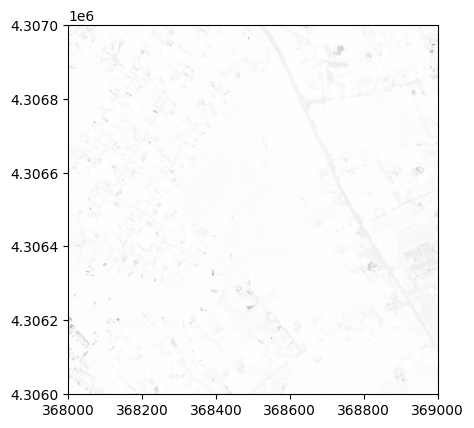

In [24]:
serc_plot = plt.imshow(b56,extent=serc_ext,cmap='Greys') 

We can see that this image looks pretty washed out. To see why this is, it helps to look at the range and distribution of reflectance values that we are plotting. We can do this by making a histogram. 

## Plot histogram

We can plot a histogram using the `matplotlib.pyplot.hist` function. Note that this function won't work if there are any NaN values, so we can ensure we are only plotting the real data values using the call below. You can also specify the # of bins you want to divide the data into. 

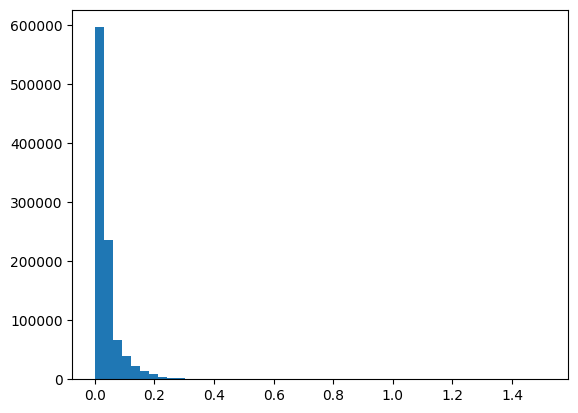

In [25]:
plt.hist(b56[~np.isnan(b56)],50); #50 signifies the # of bins

We can see that most of the reflectance values are < 0.4. In order to show more contrast in the image, we can adjust the colorlimit (`clim`) to 0-0.4:

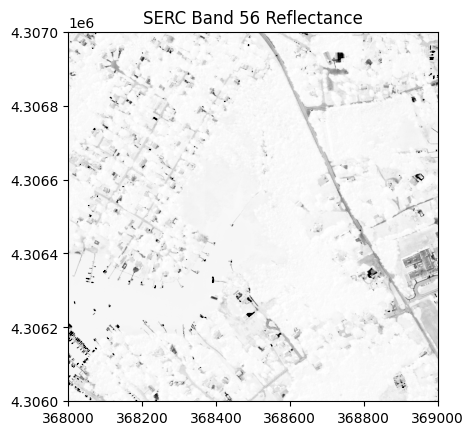

In [26]:
serc_plot = plt.imshow(b56,extent=serc_ext,cmap='Greys',clim=(0,0.4)) 
plt.title('SERC Band 56 Reflectance');

Here you can see that adjusting the colorlimit displays features (eg. roads, buildings) much better than when we set the colormap limits to the entire range of reflectance values. 

## Optional Exercise: Image Processing -- Contrast Stretch & Histogram Equalization 

We can also try out some basic image processing to better visualize the reflectance data using the `scikit-image` package. 

Histogram equalization is a method in image processing of contrast adjustment using the image's histogram. Stretching the histogram can improve the contrast of a displayed image, as we will show how to do below. 

The following code is adapted from scikit-image's tutorial
<a href="http://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html#sphx-glr-auto-examples-color-exposure-plot-equalize-py" target="_blank"> Histogram Equalization</a>.

Below we demonstrate a widget to interactively explore different linear contrast stretches: